## Module

In [1]:
from collections import OrderedDict
from typing import List, Tuple
from transformers import AdamW
from transformers import logging
from datasets import load_dataset
from evaluate import load as load_metric
from transformers import DataCollatorForSeq2Seq

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pdb

from torch.utils.data import DataLoader, random_split
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from src.peft import get_peft_config, get_peft_model, PeftConfig, LoraConfig, PeftModel, TaskType, PrefixTuningConfig

import flwr as fl
from flwr.common import Metrics

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2,3,4,5,6,7"


from dataloader import CustomDataset, CustomPartition
from easydict import EasyDict

/home/ckjwh/anaconda3/envs/FedML/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training on cuda using PyTorch 2.0.1+cu117 and Flower 1.5.0


## Setting

In [2]:
# load dataset
args1 = EasyDict({
    "client_num" : 5,
    "data_file" : "/home/ckjwh/ckj/FedML/python/app/fednlp/fednlp_data/data_files/cornell_movie_dialogue_data.h5",
    "task_type" : "seq2seq",
    "embedding_file" : "/home/ckjwh/ckj/FedML/python/app/fednlp/fednlp_data/embedding_files/cornell_movie_dialogue_embedding.pkl",
    "overwrite" : False,
    "batch" : 16,
    "embedding_exist" : False
})

In [3]:
# Create CustomDataset instance
custom_dataset = CustomDataset(args1)
# Load datasets
df = custom_dataset.load_datasets()

start reading data
start process embedding data and kmeans partition


Batches: 100%|██████████| 6915/6915 [01:48<00:00, 63.58it/s]


start Kmeans


/home/ckjwh/anaconda3/envs/FedML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
end Kmeans


In [4]:
df

,Input,Label,assigned
0,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....,4
1,Right. See? You're ready for the quiz.,I just wanted --,2
2,Why should I carry your bag? I am not a dog.,Wording and your friendship with the Colonel a...,3
3,Let me try.,You? Why I'm sure it would pale in comparison ...,3
4,Let me try!,That... was... no... simulation.,1
...,...,...,...
110622,"I'm through with puppets, Lotte. I just want y...",I know.,4
110623,I'd like to be a farmer. I want to help things...,Sure. We could really use a farmer. We'd be gr...,3
110624,I can't believe it. This is too good to be true.,"Holy shit, yes!",0
110625,Holy shit! He said what I said!,Holy shit! He said what I said!,0


In [5]:
# cluster results
df.assigned.value_counts()

assigned
4    31522
3    29898
2    19370
1    15026
0    14811
Name: count, dtype: int64

In [6]:
# partition dataset
args2 = EasyDict({
    "num_clients": 5,
    "dataframe": df, 
    "alpha": 5,   
    "val_ratio": 0.2,
    "imbalance": True,
    "random_state": None
})

In [7]:
# Create CustomPartition instance
cp = CustomPartition(args2)
partitions = cp.data_partition()

In [8]:
# distribute clients'data
clients = cp.data_distribution(partitions)

In [9]:
# count label per clients
cp.count_labels(partitions)

Counter({0: 6985, 4: 5347, 1: 3467, 2: 3243, 3: 3084})
Counter({0: 6556, 1: 6056, 3: 4029, 4: 3170, 2: 2315})
Counter({2: 7821, 4: 5652, 3: 4183, 1: 3199, 0: 1270})
Counter({4: 10263, 2: 5991, 3: 3567, 1: 2304})
Counter({3: 15035, 4: 7090})


In [10]:
from sklearn.model_selection import train_test_split

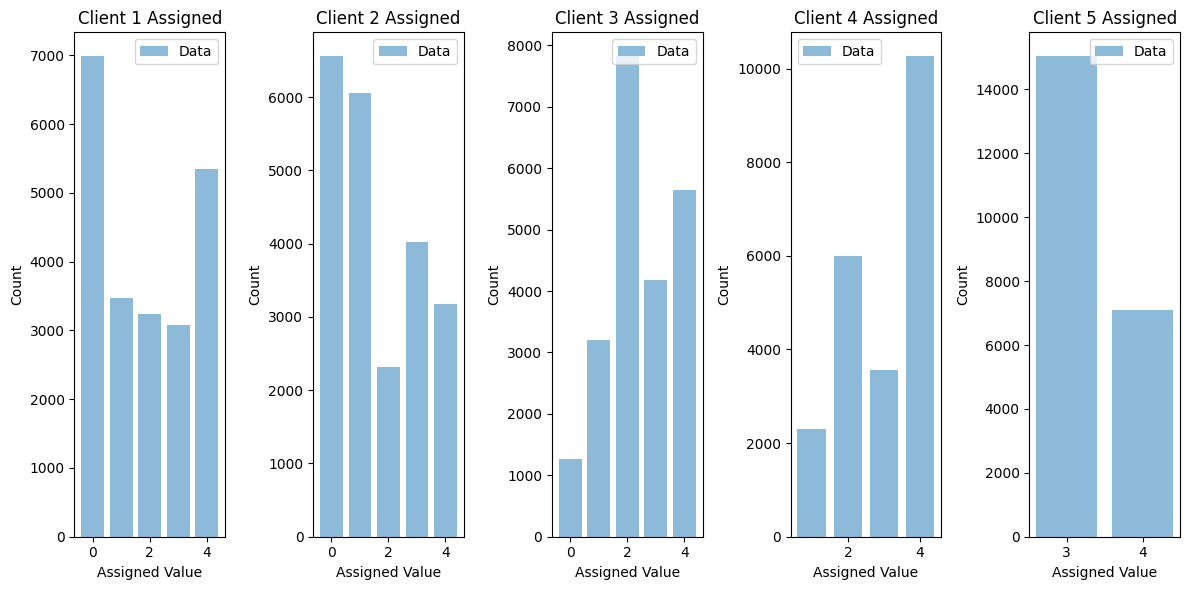

In [11]:
# data distribution
cp.data_visualization(partitions)

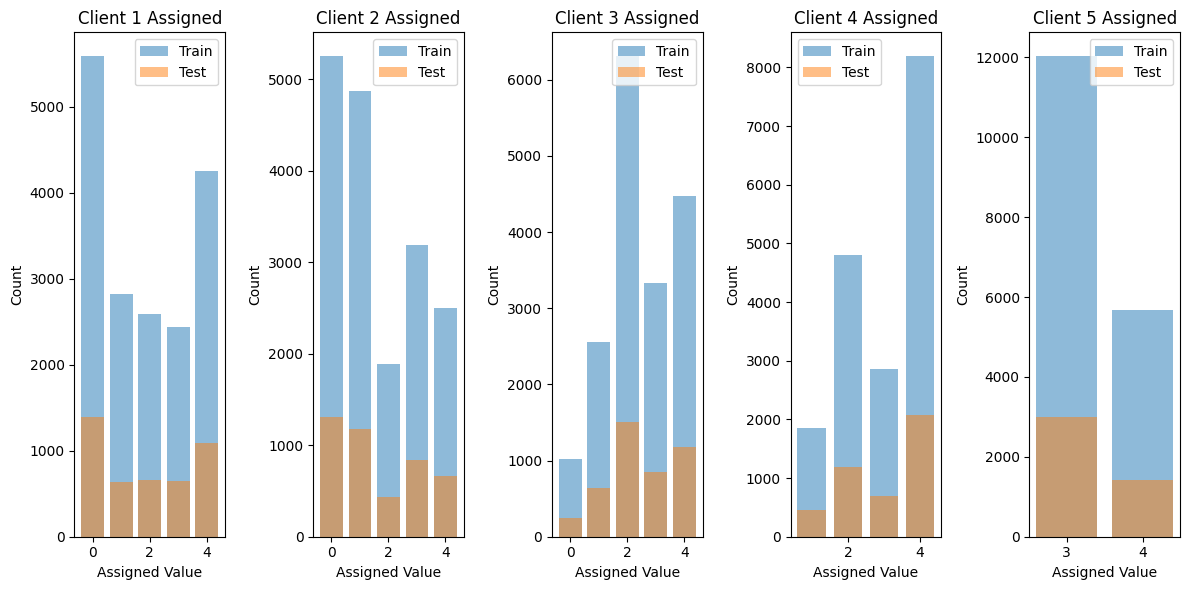

In [12]:
# train, test distribution
cp.split_visualization(clients)

In [13]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")

Downloading: 100%|██████████| 2.48k/2.48k [00:00<00:00, 5.03MB/s]
Downloading: 100%|██████████| 773k/773k [00:00<00:00, 6.01MB/s]
Downloading: 100%|██████████| 2.31M/2.31M [00:01<00:00, 2.26MB/s]
Downloading: 100%|██████████| 2.15k/2.15k [00:00<00:00, 5.08MB/s]
Downloading: 100%|██████████| 1.37k/1.37k [00:00<00:00, 3.60MB/s]
Downloading: 100%|██████████| 294M/294M [00:52<00:00, 5.82MB/s] 


In [75]:
def preprocess_function(examples):
    max_input_length = 64
    max_target_length = 30

    input_texts = examples["Input"]
    label_texts = examples["Label"]
    
    model_inputs = tokenizer(
        input_texts,
        max_length=max_input_length,
        truncation=True,
    )

    labels = tokenizer(
        label_texts,
        max_length=max_target_length,
        truncation=True,
    )

    model_inputs["labels"] = labels["input_ids"]

    return model_inputs


In [148]:
from datasets import Dataset

train_set = []
test_set = []
CHECKPOINT = "google/flan-t5-small"

for client in clients:
    # train
    train_set.append(Dataset.from_pandas(client[0][['Input', 'Label']]))
    
    # test
    test_set.append(Dataset.from_pandas(client[1][['Input', 'Label']]))
    
    
def load_datasets():
    trainloader = []
    testloader = []
    
    # # Create CustomDataset instance
    # custom_dataset = CustomDataset(args1)
    
    # # Load datasets
    # df = custom_dataset.load_datasets()
    
    # # Create CustomPartition instance
    # cp = CustomPartition(args2)
    # partitions = cp.data_partition()
    
    # # distribute clients'data
    # clients = cp.data_distribution(partitions)
    
    model = AutoModelForSeq2SeqLM.from_pretrained(CHECKPOINT)
    tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)


    tokenized_train = [dataset.map(preprocess_function, remove_columns=train_set[0].column_names) for dataset in train_set]
    tokenized_test= [dataset.map(preprocess_function, remove_columns=test_set[0].column_names) for dataset in test_set]
    
    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
    for dataset in tokenized_train:
        
        
        loader = DataLoader(
            dataset,
            shuffle=True,
            batch_size=8,
            collate_fn=data_collator
        )
        
        trainloader.append(loader)
        
        
    for dataset in tokenized_test:
        
        loader = DataLoader(
            dataset,
            batch_size=8,
            collate_fn=data_collator
        )
        
        testloader.append(loader)
        

    return trainloader, testloader

In [149]:
trainloaders, testloaders = load_datasets()

Map: 100%|██████████| 4425/4425 [00:01<00:00, 2390.83 examples/s]


In [168]:
from nltk.tokenize import sent_tokenize

import evaluate
import pdb

def train(net, trainloader, epochs):
    optimizer = AdamW(net.parameters(), lr=5e-5)
    net.train()
    losses = 0
    for _ in range(epochs):
        for batch in trainloader:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            outputs = net(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses += loss.item()
        
        print(f"loss : {loss / len(trainloader)}")

def test(net, testloader):
    rouge_score = evaluate.load("rouge")
    loss = 0
    net.eval()
    score_list = []
    for batch in testloader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        labels = batch['labels'].cpu()
        input_ids = batch['input_ids'].cpu()
        
        
        with torch.no_grad():
            predictions = net.generate(input_ids, max_length = 70)
        
        decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
        decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
        rouge_score.add_batch(predictions=decoded_preds, references=decoded_labels)       
        
        
    # Extract the median ROUGE scores
    result = rouge_score.compute()
    print(decoded_preds)
    print(decoded_labels)
    result = {key: value for key, value in result.items()}
    result = {k: round(v, 4) for k, v in result.items()}
    return result['rouge2'], result['rouge2']

In [151]:
train(model.to(DEVICE), trainloaders[0], 1)

loss : 0.0019553271122276783


In [ ]:
# train(model.to(DEVICE), trainloaders[0], 1)
res_list = []
for i in range(5):
    res = test(model.to(DEVICE), testloaders[i])
    res_list.append(res)

In [25]:
ss = 0
for i in res_list:
    ss += i[0]

ss/5

0.7130600000000001

In [19]:
class IMDBClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, testloader):
        self.net = net
        self.trainloader = trainloader
        self.testloader = testloader

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]

    def set_parameters(self, parameters):
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        self.net.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        print("Training Started...")
        train(self.net, self.trainloader, epochs=1)
        print("Training Finished.")
        return self.get_parameters(config={}), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, accuracy = test(self.net, self.testloader)
        return float(loss), len(self.testloader), {"accuracy": float(accuracy), "loss": float(loss)}

In [20]:
class PrefixClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, testloader):
        self.net = net
        self.trainloader = trainloader
        self.testloader = testloader

    def get_parameters(self, config):
        return self.net.get_prompt_parameters()

    def set_parameters(self, parameters):
        self.net.set_prompt_parameters(parameters)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        print("Training Started...")
        train(self.net, self.trainloader, epochs=1)
        print("Training Finished.")
        return self.get_parameters(config={}), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, accuracy = test(self.net, self.testloader)
        return float(loss), len(self.testloader), {"accuracy": float(accuracy), "loss": float(loss)}

In [21]:
def client_fn(cid: str) -> IMDBClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = model.to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = testloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return IMDBClient(net, trainloader, valloader)

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=1.0,  # Sample 50% of available clients for evaluation
    min_fit_clients=5,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=5,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

NUM_CLIENTS = 5
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
#     ray_init_args={"include_dashboard": False}
)

INFO flwr 2023-08-05 13:49:00,477 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-08-05 13:49:03,282	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-08-05 13:49:04,706 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 29529923174.0, 'GPU': 6.0, 'memory': 59059846350.0, 'accelerator_type:RTX': 1.0, 'CPU': 40.0, 'node:__internal_head__': 1.0, 'node:202.30.1.208': 1.0}
INFO flwr 2023-08-05 13:49:04,708 | server.py:86 | Initializing global parameters
INFO flwr 2023-08-05 13:49:04,710 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-08-05 13:49:25,151 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-08-05 13:49:25,154 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-08-05 13:49:25,155 | server.py:101 | FL starting
DEBUG flwr 2023-08-05 13:49:25,157 | server.py:218 | fit_round 1: strategy sampled 5 clients (out of 5)
(launch_and_fit pid=38394) /home/qudgks/miniconda3/envs/FL/lib/python3.8/site-packages/transformers/optimization.py:

(launch_and_fit pid=38394) Training Started...
(launch_and_fit pid=38481) loss : 0.0036469155456870794
(launch_and_fit pid=38481) Training Finished.
(launch_and_fit pid=38496) Training Started... [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(launch_and_fit pid=38437) loss : 0.003442393383011222
(launch_and_fit pid=38437) Training Finished.
(launch_and_fit pid=38496) loss : 0.002363845007494092
(launch_and_fit pid=38496) Training Finished.
(launch_and_fit pid=38394) loss : 0.0023197701666504145
(launch_and_fit pid=38394) Training Finished.
(launch_and_fit pid=38577) loss : 0.001842861413024366
(launch_and_fit pid=38577) Training Finished.


DEBUG flwr 2023-08-05 13:56:59,259 | server.py:232 | fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-08-05 13:57:23,265 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-08-05 13:57:23,298 | server.py:168 | evaluate_round 1: strategy sampled 5 clients (out of 5)
(launch_and_fit pid=38496) /home/qudgks/miniconda3/envs/FL/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning [repeated 4x across cluster]
(launch_and_fit pid=38496)   warnings.warn( [repeated 4x across cluster]
(launch_and_evaluate pid=3857) You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding. [r

(launch_and_evaluate pid=3960) ['Uh-huh!']
(launch_and_evaluate pid=3960) ['Uh-huh!']
(launch_and_evaluate pid=3961) ["I know.\nI'm sorry.\nI'm sorry.\nI'm sorry.\nI'm sorry.", 'Nonsense No.']
(launch_and_evaluate pid=3961) ["I know.\nI'm sorry.", 'Nonsense']
(launch_and_evaluate pid=3857) ["Other than Brill.\nI'm not sure.", "No, you guys are great together.\nHe'll come through, I'm sure.\nI'm not.", "I don't care what you believe.\nI saved your life once, I don't plan on making a habit of it.\nYou're a shithole."]
(launch_and_evaluate pid=3857) ['Other than Brill.', "No, you guys are great together.\nHe'll come through, I'm sure.", "I don't care what you believe.\nI saved your life once, I don't plan on making a habit of it.\nYou"]
(launch_and_evaluate pid=3890) ["Funnier to who and at who's expense?\nDunwitty, when Negroes start to run amok, the boycotts are a thing of the past.", "Yes, with your clients' names attached.\nThat's the only reason those poor slobs pay you - to see thei

DEBUG flwr 2023-08-05 14:03:13,170 | server.py:182 | evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2023-08-05 14:03:13,172 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-08-05 14:03:13,174 | server.py:218 | fit_round 2: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=3952) ["... That's funny...\nI had this job with Enzo... we got fired too.", "Five and a half minutes.\nHe's breached the hot zone..\nI'm not sure.", "No.\nNever heard of him.\nI'm not sure.", "A what?\nI'm a paleontologist.", "What was the color of Tim's belt?\nI'm not sure.\nI'm not sure.", "No.\nHeadin' west.\nTo Can-tuck-ee.\nI'm not sure."]
(launch_and_evaluate pid=3952) ["... That's funny...\nI had this job with Enzo... we got fired too.", "Five and a half minutes.\nHe's breached the hot zone..", 'No.\nNever heard of him.', 'A what?', "What was the color of Tim's belt?", "No.\nHeadin' west.\nTo Can-tuck-ee."]
(launch_and_fit pid=8601) Training Started...


(launch_and_fit pid=8601) /home/qudgks/miniconda3/envs/FL/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(launch_and_fit pid=8601)   warnings.warn(
(launch_and_fit pid=8601) You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding. [repeated 5x across cluster]
(launch_and_fit pid=8650) /home/qudgks/miniconda3/envs/FL/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(l

(launch_and_fit pid=8601) loss : 0.00420457823202014
(launch_and_fit pid=8601) Training Finished.
(launch_and_fit pid=8703) Training Started... [repeated 4x across cluster]
(launch_and_fit pid=8709) loss : 0.003306831931695342
(launch_and_fit pid=8709) Training Finished.
(launch_and_fit pid=8708) loss : 0.0031282224226742983
(launch_and_fit pid=8708) Training Finished.
(launch_and_fit pid=8650) loss : 0.002395196119323373
(launch_and_fit pid=8650) Training Finished.
(launch_and_fit pid=8703) loss : 0.0020141578279435635
(launch_and_fit pid=8703) Training Finished.


DEBUG flwr 2023-08-05 14:10:30,188 | server.py:232 | fit_round 2 received 5 results and 0 failures
DEBUG flwr 2023-08-05 14:10:43,366 | server.py:168 | evaluate_round 2: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=13837) You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding. [repeated 5x across cluster]
(launch_and_fit pid=8703) /home/qudgks/miniconda3/envs/FL/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning [repeated 3x across cluster]
(launch_and_fit pid=8703)   warnings.warn( [repeated 3x across cluster]


(launch_and_evaluate pid=13875) ['Uh-huh!']
(launch_and_evaluate pid=13875) ['Uh-huh!']
(launch_and_evaluate pid=13879) ["I know.\nI'm sorry.\nI'm sorry.\nI'm sorry.\nI'm sorry.\nI'm sorry.", "Nonsense No, I don't know."]
(launch_and_evaluate pid=13879) ["I know.\nI'm sorry.", 'Nonsense']


(launch_and_fit pid=18286) You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding. [repeated 5x across cluster]
(launch_and_fit pid=18286) /home/qudgks/miniconda3/envs/FL/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(launch_and_fit pid=18286)   warnings.warn(


(launch_and_fit pid=18286) Training Started...


(launch_and_fit pid=18332) /home/qudgks/miniconda3/envs/FL/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(launch_and_fit pid=18332)   warnings.warn(
ERROR flwr 2023-08-05 14:17:42,951 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.30.1.208, ID: ae1cbb782a557cd6836f236eb217d718833893871463856700c995d6) where the task (task ID: 843902242f17ef64d03453d51662d230b8de25be01000000, name=launch_and_fit, pid=18372, memory used=4.90GB) was running was 119.33GB / 125.55GB (0.950422), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 2dd4f11eee880c496189eebb5507d6e037fd0d3be0477e9dfbf7a806) because it was the most recently scheduled task; to see more information about memory usa

(launch_and_fit pid=18362) loss : 0.001979973865672946
(launch_and_fit pid=18362) Training Finished.
(launch_and_fit pid=18363) Training Started... [repeated 4x across cluster]
(launch_and_fit pid=18332) loss : 0.0036319708451628685
(launch_and_fit pid=18332) Training Finished.
(launch_and_fit pid=18286) loss : 0.0025100158527493477
(launch_and_fit pid=18286) Training Finished.
(launch_and_fit pid=18363) loss : 0.001948125078342855
(launch_and_fit pid=18363) Training Finished.


DEBUG flwr 2023-08-05 14:24:12,680 | server.py:232 | fit_round 3 received 4 results and 1 failures
DEBUG flwr 2023-08-05 14:24:21,268 | server.py:168 | evaluate_round 3: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=23877) You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding. [repeated 5x across cluster]
(launch_and_fit pid=18363) /home/qudgks/miniconda3/envs/FL/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning [repeated 3x across cluster]
(launch_and_fit pid=18363)   warnings.warn( [repeated 3x across cluster]


(launch_and_evaluate pid=23947) ["I know.\nI'm sorry.\nI'm sorry.\nI'm sorry.\nI'm sorry.\nI'm sorry.\nI'm sorry.", "Nonsense No, I'm not."]
(launch_and_evaluate pid=23947) ["I know.\nI'm sorry.", 'Nonsense']
(launch_and_evaluate pid=23945) ['Uh-huh!']
(launch_and_evaluate pid=23945) ['Uh-huh!']
(launch_and_evaluate pid=23877) ["Funnier to who and at who's expense?\nDunwitty, when Negroes start to run amok, the boycotts", "Yes, with your clients' names attached.\nThat's the only reason those poor slobs pay you - to see their names", "Dr. Bloom showed me your article on surgical addiction in the journal of Clinical Psychiatry.\nI'm sorry, I'm sorry.", "It's the truth.\nThose 17 superstars are our insurance policy.\nWe can't open -- can't make a profit --", "Losing power.\nThe laser drained it.\nI'm sorry, Mr. Sullivan.", "You mock us with a smile?\nI'm sorry, Mr. Smith.", "I've got my Dr. Gruber, says her heart condition means they gave her the wrong anaesthetic anyway, plus she's"]
(la

DEBUG flwr 2023-08-05 14:31:34,239 | server.py:182 | evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-08-05 14:31:34,242 | server.py:218 | fit_round 4: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=23956) ["... That's funny...\nI had this job with Enzo... we got fired too.", "Five and a half minutes.\nHe's breached the hot zone..\nI'm not sure.", "No.\nNever heard of him.\nI'm not sure.", "A what?\nI'm a paleontologist.", "What was the color of Tim's belt?\nI'm sorry, I'm sorry, I'm sorry.\nI'm sorry, I'm sorry.\nI'm sorry.\nI'm sorry.\nI'm sorry.\nI'm sorry.\nI'm sorry", "No.\nHeadin' west.\nTo Can-tuck-ee.\nI'm not a shit."]
(launch_and_evaluate pid=23956) ["... That's funny...\nI had this job with Enzo... we got fired too.", "Five and a half minutes.\nHe's breached the hot zone..", 'No.\nNever heard of him.', 'A what?', "What was the color of Tim's belt?", "No.\nHeadin' west.\nTo Can-tuck-ee."]
(launch_and_fit pid=29362) Training Started...


(launch_and_fit pid=29362) You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding. [repeated 5x across cluster]
(launch_and_fit pid=29362) /home/qudgks/miniconda3/envs/FL/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(launch_and_fit pid=29362)   warnings.warn(
(launch_and_fit pid=29399) /home/qudgks/miniconda3/envs/FL/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warnin

(launch_and_fit pid=29398) loss : 0.003506239503622055
(launch_and_fit pid=29398) Training Finished.
(launch_and_fit pid=29398) Training Started... [repeated 4x across cluster]


ERROR flwr 2023-08-05 14:35:34,185 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 202.30.1.208, ID: ae1cbb782a557cd6836f236eb217d718833893871463856700c995d6) where the task (task ID: aed910ef068462814962d550224f77ef375596fa01000000, name=launch_and_fit, pid=29407, memory used=4.90GB) was running was 119.44GB / 125.55GB (0.951296), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 7d39044dfafe8d269d67052c48784bae7fb0bc5e56fcc92b7d2fdf92) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 202.30.1.208`. To see the logs of the worker, use `ray logs worker-7d39044dfafe8d269d67052c48784bae7fb0bc5e56fcc92b7d2fdf92*out -ip 202.30.1.208. Top 10 memory users:
PID	MEM(GB)	COMMAND
35941	37.69	/home/qudgks/miniconda3/envs/FL/bin/python -m ipykernel_launcher -f /home/qudgks/.local/share/jupyte...
29398	6.79	ray::launch_and_fit
278

(launch_and_fit pid=29399) loss : 0.003731293836608529
(launch_and_fit pid=29399) Training Finished.


(raylet) [2023-08-05 14:36:03,299 E 36800 36800] (raylet) node_manager.cc:3084: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: ae1cbb782a557cd6836f236eb217d718833893871463856700c995d6, IP: 202.30.1.208) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 202.30.1.208`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(launch_and_fit pid=29362) loss : 0.002389580477029085
(launch_and_fit pid=29362) Training Finished.
(launch_and_fit pid=29401) loss : 0.0015749313170090318
(launch_and_fit pid=29401) Training Finished.


DEBUG flwr 2023-08-05 14:38:51,279 | server.py:232 | fit_round 4 received 4 results and 1 failures
DEBUG flwr 2023-08-05 14:38:59,226 | server.py:168 | evaluate_round 4: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=34823) You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding. [repeated 5x across cluster]
(launch_and_fit pid=29398) /home/qudgks/miniconda3/envs/FL/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning [repeated 3x across cluster]
(launch_and_fit pid=29398)   warnings.warn( [repeated 3x across cluster]


(launch_and_evaluate pid=34884) ["I know.\nI'm sorry.\nI'm sorry.\nI'm sorry.\nI'm sorry.\nI'm sorry.", 'Nonsense No, no.']
(launch_and_evaluate pid=34884) ["I know.\nI'm sorry.", 'Nonsense']
(launch_and_evaluate pid=34879) ['Uh-huh!']
(launch_and_evaluate pid=34879) ['Uh-huh!']
(launch_and_evaluate pid=34873) ["Funnier to who and at who's expense?\nDunwitty, when Negroes start to run amok, the boycotts", "Yes, with your clients' names attached.\nThat's the only reason those poor slobs pay you - to see their names.", "Dr. Bloom showed me your article on surgical addiction in the journal of Clinical Psychiatry.\nI'm sorry, I'm sorry.", "It's the truth.\nThose 17 superstars are our insurance policy.\nWe can't open -- can't make a profit --", "Losing power.\nThe laser drained it.\nI'm sorry, Mr. Sullivan.", "You mock us with a smile?\nI'm not a snob.", "I've got my Dr. Gruber, says her heart condition means they gave her the wrong anaesthetic anyway, plus she's"]
(launch_and_evaluate pid=

DEBUG flwr 2023-08-05 14:46:05,549 | server.py:182 | evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2023-08-05 14:46:05,552 | server.py:218 | fit_round 5: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=34872) ["... That's funny...\nI had this job with Enzo... we got fired too.", "Five and a half minutes.\nHe's breached the hot zone..\nI'm not gonna be able to get him.", "No.\nNever heard of him.\nI'm not sure.", "A what?\nI'm a paleontologist.", "What was the color of Tim's belt?\nI'm not a shithole.\nI'm a shithole.\nI'm a shithole.\nI'm a shithole.", "No.\nHeadin' west.\nTo Can-tuck-ee.\nI'm not a snob."]
(launch_and_evaluate pid=34872) ["... That's funny...\nI had this job with Enzo... we got fired too.", "Five and a half minutes.\nHe's breached the hot zone..", 'No.\nNever heard of him.', 'A what?', "What was the color of Tim's belt?", "No.\nHeadin' west.\nTo Can-tuck-ee."]
(launch_and_fit pid=617) Training Started...


(launch_and_fit pid=617) You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding. [repeated 5x across cluster]
(launch_and_fit pid=617) /home/qudgks/miniconda3/envs/FL/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(launch_and_fit pid=617)   warnings.warn(
(launch_and_fit pid=693) /home/qudgks/miniconda3/envs/FL/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(launc

(launch_and_fit pid=660) loss : 0.004065924324095249
(launch_and_fit pid=660) Training Finished.
(launch_and_fit pid=703) Training Started... [repeated 4x across cluster]
(launch_and_fit pid=617) loss : 0.0026054889895021915
(launch_and_fit pid=617) Training Finished.
(launch_and_fit pid=695) loss : 0.0022846651263535023
(launch_and_fit pid=695) Training Finished.
(launch_and_fit pid=693) loss : 0.0015613093273714185
(launch_and_fit pid=693) Training Finished.


DEBUG flwr 2023-08-05 14:53:19,999 | server.py:232 | fit_round 5 received 4 results and 1 failures
DEBUG flwr 2023-08-05 14:53:31,438 | server.py:168 | evaluate_round 5: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=7138) You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding. [repeated 5x across cluster]
(launch_and_fit pid=703) /home/qudgks/miniconda3/envs/FL/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning [repeated 3x across cluster]
(launch_and_fit pid=703)   warnings.warn( [repeated 3x across cluster]


(launch_and_evaluate pid=7171) ["Funnier to who and at who's expense?\nDunwitty, when Negroes start to run amok, the boycotts", "Yes, with your clients' names attached.\nThat's the only reason those poor slobs pay you - to see their names", "Dr. Bloom showed me your article on surgical addiction in the journal of Clinical Psychiatry.\nI'm sorry, I'm sorry.", "It's the truth.\nThose 17 superstars are our insurance policy.\nWe can't open -- can't make a profit --", "Losing power.\nThe laser drained it.\nI'm not sure.", "You mock us with a smile?\nI'm not a snob.", "I've got my Dr. Gruber, says her heart condition means they gave her the wrong anaesthetic anyway, plus she's"]
(launch_and_evaluate pid=7171) ["Funnier to who and at who's expense?\nDunwitty, when Negroes start to run amok, the boycotts", "Yes, with your clients' names attached.\nThat's the only reason those poor slobs pay you - to see their names", 'Dr. Bloom showed me your article on surgical addiction in the journal of Cli

DEBUG flwr 2023-08-05 15:00:39,118 | server.py:182 | evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2023-08-05 15:00:39,120 | server.py:218 | fit_round 6: strategy sampled 5 clients (out of 5)


(launch_and_evaluate pid=7138) ["... That's funny...\nI had this job with Enzo... we got fired too.", "Five and a half minutes.\nHe's breached the hot zone..\nI'm not going to be able to get him.", "No.\nNever heard of him.\nI'm not sure.", "A what?\nI'm a paleontologist.", "What was the color of Tim's belt?\nI'm not sure.\nI'm not sure.\nI'm not sure.\nI'm not sure.\nI'm not sure.\nI'm not sure.\nI'm not sure.\nI'm not sure.\nI", "No.\nHeadin' west.\nTo Can-tuck-ee.\nI'm not going to bet on it."]
(launch_and_evaluate pid=7138) ["... That's funny...\nI had this job with Enzo... we got fired too.", "Five and a half minutes.\nHe's breached the hot zone..", 'No.\nNever heard of him.', 'A what?', "What was the color of Tim's belt?", "No.\nHeadin' west.\nTo Can-tuck-ee."]
(launch_and_fit pid=12386) Training Started...


(launch_and_fit pid=12386) You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding. [repeated 5x across cluster]
(launch_and_fit pid=12386) /home/qudgks/miniconda3/envs/FL/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(launch_and_fit pid=12386)   warnings.warn(
(launch_and_fit pid=12441) /home/qudgks/miniconda3/envs/FL/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warnin

In [24]:
history

History (loss, distributed):
	round 1: 0.710209068776628
	round 2: 0.6990351186853316
	round 3: 0.6785576384662204
	round 4: 0.6928872793670116
	round 5: 0.6753511868533172
	round 6: 0.6980922253922968
	round 7: 0.6756048691418136
	round 8: 0.6608476708074534
	round 9: 0.7113708460133902
	round 10: 0.6638261107729764

In [ ]:
#base line
History (loss, distributed):
	round 1: 0.710209068776628
	round 2: 0.6990351186853316
	round 3: 0.6785576384662204
	round 4: 0.6928872793670116
	round 5: 0.6753511868533172
	round 6: 0.6980922253922968
	round 7: 0.6756048691418136
	round 8: 0.6608476708074534
	round 9: 0.7113708460133902
	round 10: 0.6638261107729764

In [ ]:
# prefix round 10
History (loss, distributed):
	round 1: 0.7222987827145466
	round 2: 0.7267468654899574
	round 3: 0.7276815581253804
	round 4: 0.7292324406573341
	round 5: 0.7272822276323798
	round 6: 0.729241387705417
	round 7: 0.7286804625684723
	round 8: 0.7295257455873402
	round 9: 0.7313477175897748
	round 10: 0.7306583688374925

In [ ]:
#round 2 prefix
History (loss, distributed):
	round 1: 0.7422124581175754
	round 2: 0.7481604629911666
# round 2 baseline
History (loss, distributed):
	round 1: 0.7218715199512641
	round 2: 0.7248902223575997

In [ ]:
# def weighted_average(metrics):
#     accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
#     losses = [num_examples * m["loss"] for num_examples, m in metrics]
#     examples = [num_examples for num_examples, _ in metrics]
#     return {"accuracy": sum(accuracies) / sum(examples), "loss": sum(losses) / sum(examples)}

# strategy = fl.server.strategy.FedAvg(
#     fraction_fit=1.0,
#     fraction_evaluate=1.0,
#     evaluate_metrics_aggregation_fn=weighted_average,
# )

# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=NUM_CLIENTS,
#     config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
#     strategy=strategy,
#     client_resources={"num_cpus": 1, "num_gpus": 0},
#     ray_init_args={"log_to_driver": False, "num_cpus": 1, "num_gpus": 0}
# )

In [ ]:
hostory